In [2]:
# FAISS IVF vs FlatL2 on SIFT1M

import faiss
import numpy as np
import time
import os

# --------------------------
# Step 1: Load SIFT1M Dataset
# --------------------------
def read_fvecs(file_path):
    with open(file_path, 'rb') as f:  
        dim = 128
        vectors = np.fromfile(f, dtype=np.float32)
        indices_to_remove = np.arange(0, len(vectors), dim+1)
        vectors = np.delete(vectors, indices_to_remove)
        vectors = vectors.reshape(int(len(vectors)/dim), dim)
    return vectors

def read_ivecs(path):
    a = np.fromfile(path, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:]

base_path = "./sift1m_files"  # Replace with your path
data = read_fvecs(os.path.join(base_path, 'sift_base.fvecs'))
queries = read_fvecs(os.path.join(base_path, 'sift_query.fvecs'))
ground_truth = read_ivecs(os.path.join(base_path, 'sift_groundtruth.ivecs'))

n = 1000000
d = 128
k = 10

In [3]:
# Re-imports after environment reset
import numpy as np
import faiss
import time
from collections import defaultdict
from sklearn.metrics import pairwise_distances
import heapq

# --- Build FAISS HNSW Index ---
M = 16
index = faiss.IndexHNSWFlat(d, M)
index.hnsw.efConstruction = 40
index.add(data)

print("Index built")

# Extract graph from FAISS
neighbors = faiss.vector_to_array(index.hnsw.neighbors)
offsets = faiss.vector_to_array(index.hnsw.offsets)

hnsw_graph = {
    i: [j for j in neighbors[offsets[i]:offsets[i + 1]] if j != -1 and j < n and j != i]
    for i in range(n)
}

# --- 🧮 Count directed edges ---
num_edges_hnsw = sum(len(nbrs) for nbrs in hnsw_graph.values())
print(f"\nNumber of directed edges in HNSW graph: {num_edges_hnsw}")

Index built

Number of directed edges in HNSW graph: 15482555


In [4]:
import heapq
import numpy as np

def hnsw_search_layer(query, data, graph, entry_point, k, ef):
    """
    Faithful implementation of HNSW SEARCH-LAYER (layer 0 only).

    Args:
        query:        query vector (1D np.array)
        data:         dataset array of shape (n, d)
        graph:        dictionary {i: [neighbor indices]} representing HNSW layer 0
        entry_point:  index of starting node
        k:            number of nearest neighbors to return
        ef:           size of dynamic list W (controls recall vs speed)

    Returns:
        knn_result: list of (distance, index) for top-k neighbors
        visited:    set of visited node indices
    """
    visited = set()
    visited.add(entry_point)

    # W: max-heap of closest points found so far (-dist, index)
    W = [(-np.sum((query - data[entry_point]) ** 2), entry_point)]

    # C: min-heap of candidate nodes to expand (dist, index)
    C = [(np.sum((query - data[entry_point]) ** 2), entry_point)]

    while C:
        dist_c, c = heapq.heappop(C)
        if dist_c > -W[0][0]:
            break

        for neighbor in graph.get(c, []):
            if neighbor in visited:
                continue
            visited.add(neighbor)

            dist = np.sum((query - data[neighbor]) ** 2)

            if len(W) < ef or dist < -W[0][0]:
                heapq.heappush(C, (dist, neighbor))
                heapq.heappush(W, (-dist, neighbor))
                if len(W) > ef:
                    heapq.heappop(W)

    # Get top-k from W (sort by distance)
    top_k = sorted([(-d, idx) for d, idx in W])[:k]
    return top_k, visited

In [5]:
ef_search = 300

# --- Run Search ---
def evaluate_graph(graph, name):
    recalls = []
    visit_counts = []
    start = time.time()
    
    for i, q in enumerate(queries):
        entry_point = 0
        result, visited = hnsw_search_layer(q, data, graph, entry_point=entry_point, k=k, ef=ef_search)
        found = [idx for _, idx in result]
        correct = ground_truth[i]
        intersect = len(set(found) & set(correct))
        recalls.append(intersect / k)
        visit_counts.append(len(visited))
    
    elapsed = time.time() - start
    avg_recall = np.mean(recalls)
    avg_visited = np.mean(visit_counts)
    
    print(f"{name} — Avg Recall: {avg_recall:.4f}, Avg Nodes Visited: {avg_visited:.1f}, Time: {elapsed:.2f} sec")

evaluate_graph(hnsw_graph, "HNSW (FAISS)")

HNSW (FAISS) — Avg Recall: 0.9784, Avg Nodes Visited: 3571.9, Time: 156.29 sec


In [6]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

def hnsw_search_layer_logged(query, data, graph, entry_point, k, ef, log_every=1):
    """
    Returns checkpoints as (furthest_rank_so_far, best_dist, current_topk_indices).

    'furthest_rank_so_far' is the running maximum, over expanded nodes, of the
    rank of the just-expanded node c within the current W (1 = closest).
    """
    visited = set([entry_point])
    d0 = np.sum((query - data[entry_point])**2)

    # Max-heap of best so far (-dist, idx); Min-heap of candidates (dist, idx)
    W = [(-d0, entry_point)]
    C = [(d0, entry_point)]

    best_dist = d0
    r_expanded = 0                      # still used just to control 'log_every'
    furthest_rank_so_far = 0
    checkpoints = []

    while C:
        dist_c, c = heapq.heappop(C)

        # Standard HNSW termination check (before expansion)
        if dist_c > -W[0][0]:
            break

        # Rank of c within current W (1 = best). Works even if ties.
        # (Using strict '<' so equal distances get the same or next rank.)
        dists_W = np.fromiter((-d for d, _ in W), dtype=np.float64, count=len(W))
        c_rank = 1 + np.count_nonzero(dists_W < dist_c)
        furthest_rank_so_far = max(furthest_rank_so_far, c_rank)

        # Explore neighbors of c
        for nbr in graph.get(c, []):
            if nbr in visited:
                continue
            visited.add(nbr)

            dist = np.sum((query - data[nbr])**2)

            if len(W) < ef or dist < -W[0][0]:
                heapq.heappush(C, (dist, nbr))
                heapq.heappush(W, (-dist, nbr))
                if len(W) > ef:
                    heapq.heappop(W)
                if dist < best_dist:
                    best_dist = dist

        r_expanded += 1
        if (r_expanded % log_every) == 0:
            top_k_now = [idx for _, idx in sorted([(-d, i) for d, i in W])[:k]]
            checkpoints.append((furthest_rank_so_far, best_dist, top_k_now))

    # Final checkpoint
    top_k_now = [idx for _, idx in sorted([(-d, i) for d, i in W])[:k]]
    checkpoints.append((furthest_rank_so_far, best_dist, top_k_now))
    return checkpoints

# --- 2) Collect labeled checkpoints over a calibration split ---
def collect_checkpoints(queries, data, graph, ground_truth, k, ef,
                        entry_point=0, max_queries=2000, log_every=1,
                        max_points=1_000_000, subsample_seed=0):
    """
    Returns:
        R_rank : array of furthest expanded rank so far (1..ef)
        Dstar  : array of best (squared) distances so far
        Y      : array of labels: 1 if current W already contains the true top-k, else 0
    """
    rng = random.Random(subsample_seed)
    R_rank, Dstar, Y = [], [], []
    total_points = 0

    for i, q in enumerate(queries[:max_queries]):
        cps = hnsw_search_layer_logged(q, data, graph, entry_point, k, ef, log_every)
        gt_k = set(ground_truth[i][:k])
        for r_rank, dstar, topk_now in cps:   # r_rank = furthest rank so far
            safe = gt_k.issubset(topk_now)
            # reservoir-like subsampling to keep plots light
            if total_points < max_points or rng.random() < max_points / (total_points + 1):
                R_rank.append(r_rank)
                Dstar.append(dstar)
                Y.append(1 if safe else 0)
            total_points += 1

    return np.array(R_rank), np.array(Dstar), np.array(Y)

def plot_checkpoints(R_rank, Dstar, Y, ef, title="HNSW level-0 checkpoints (furthest rank vs d*)",
                     alpha_safe=0.01, alpha_not_safe=0.1, size=6, use_log_x=False,
                     cut_rank=None, cut_d2=None, shade=False):
    safe_mask = (Y == 1)

    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    # points
    ax.scatter(R_rank[~safe_mask], Dstar[~safe_mask],
               s=size, c='blue', alpha=alpha_not_safe,
               edgecolors='none', rasterized=True, label='not safe')
    ax.scatter(R_rank[safe_mask],  Dstar[safe_mask],
               s=size, c='red',  alpha=alpha_safe,
               edgecolors='none', rasterized=True, label='safe')

    # guide lines
    if cut_rank is not None:
        ax.axvline(cut_rank, linestyle='--', linewidth=1.5, color='black',
                   label=f"rank = {cut_rank}")
    if cut_d2 is not None:
        ax.axhline(cut_d2, linestyle='--', linewidth=1.5, color='black',
                   label=f"d*² = {cut_d2}")

    # optional shaded "stop zone": r > cut_rank AND d*² < cut_d2
    if shade and (cut_rank is not None) and (cut_d2 is not None):
        rect = Rectangle((cut_rank, 0), max(ef - cut_rank, 0), cut_d2,
                         facecolor='gray', alpha=0.08, edgecolor='none',
                         label='proposed stop zone')
        ax.add_patch(rect)

    ax.set_xlabel("Furthest expanded rank so far (r_rank)")
    ax.set_ylabel("Best squared L2 distance d*")
    if use_log_x:
        ax.set_xscale('log')
    else:
        ax.set_xlim(1, max(ef, 2))
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    plt.show()

# --- Usage example (adjust to your params/splits) ---
ef_search = 300
k=1
R_rank, Dstar, Y = collect_checkpoints(
    queries, data, hnsw_graph, ground_truth, k, ef_search,
    entry_point=0, max_queries=2000, log_every=1,
    max_points=500_000, subsample_seed=0
)

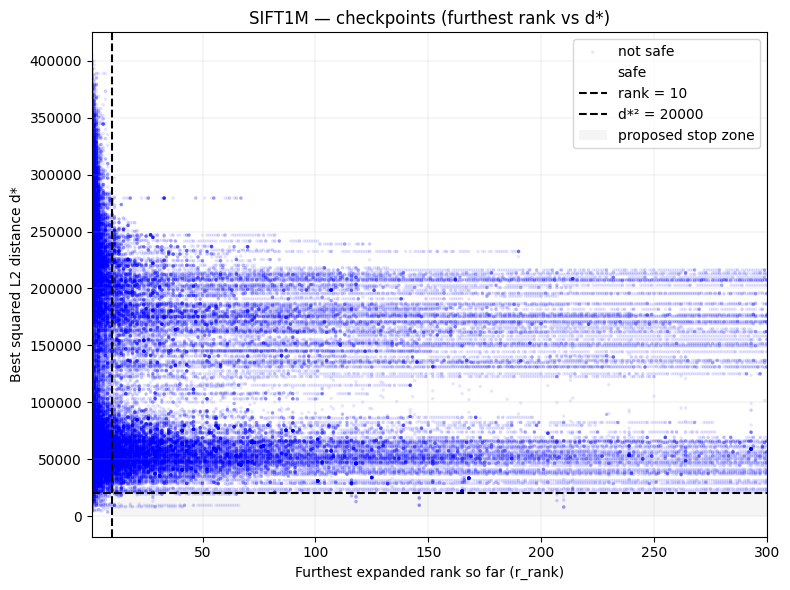

In [7]:
plot_checkpoints(
    R_rank, Dstar, Y, ef=ef_search,
    title="SIFT1M — checkpoints (furthest rank vs d*)",
    alpha_safe=0.00, alpha_not_safe=0.1, size=6,
    use_log_x=False,
    cut_rank=10, cut_d2=20_000,
    shade=True  # set False if you only want the lines
)

ef= 30 | recall=0.7200 | nodes=642.1 | 0.9s
ef= 60 | recall=0.8400 | nodes=989.9 | 2.6s
ef= 90 | recall=0.9100 | nodes=1342.3 | 4.9s
ef=120 | recall=0.9100 | nodes=1659.8 | 7.3s
ef=150 | recall=0.9100 | nodes=1961.5 | 10.3s
ef=180 | recall=0.9400 | nodes=2289.8 | 14.5s
ef=210 | recall=0.9500 | nodes=2569.7 | 18.7s
ef=240 | recall=0.9600 | nodes=2848.1 | 23.6s
ef=270 | recall=0.9600 | nodes=3119.6 | 29.7s
ef=300 | recall=0.9600 | nodes=3387.6 | 36.8s
ef= 30 | recall=0.7200 | nodes=620.4 | 0.7s
ef= 60 | recall=0.8400 | nodes=911.5 | 1.7s
ef= 90 | recall=0.9100 | nodes=1208.9 | 3.3s
ef=120 | recall=0.9100 | nodes=1472.0 | 5.6s
ef=150 | recall=0.9100 | nodes=1722.3 | 8.8s
ef=180 | recall=0.9400 | nodes=1990.7 | 11.9s
ef=210 | recall=0.9500 | nodes=2221.6 | 16.5s
ef=240 | recall=0.9600 | nodes=2450.7 | 20.5s
ef=270 | recall=0.9600 | nodes=2674.5 | 25.9s
ef=300 | recall=0.9600 | nodes=2895.4 | 31.8s


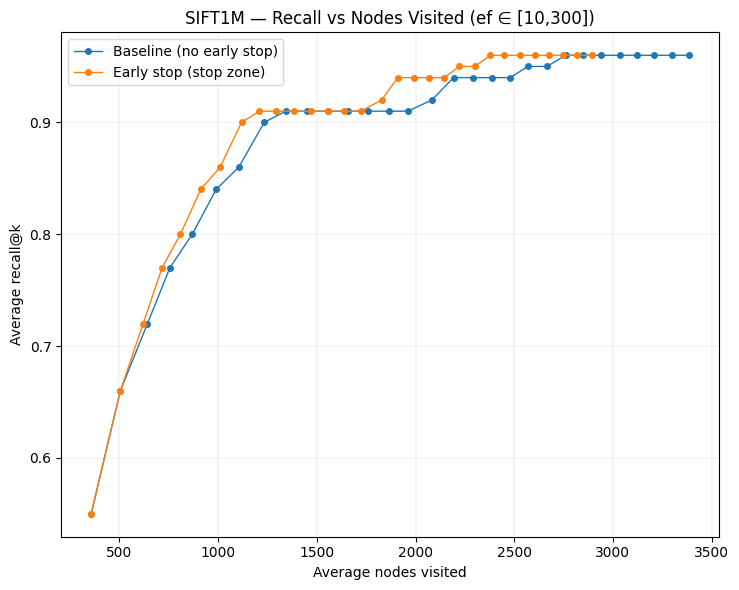

In [8]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from time import time

# ---------- Rank-aware SEARCH-LAYER with optional early stop ----------
def hnsw_search_layer_rankaware(query, data, graph, entry_point, k, ef, early_stop=None):
    """
    HNSW layer-0 search. 'early_stop' is a callable:
        early_stop(best_d2, furthest_rank_so_far, worst_in_W, visited_count) -> bool
    Returns: (top_k list of (d2, idx), visited_set)
    """
    visited = set([entry_point])
    d0 = np.sum((query - data[entry_point])**2)

    # W: max-heap of best-so-far as (-d2, idx) ; C: min-heap of candidates (d2, idx)
    W = [(-d0, entry_point)]
    C = [(d0, entry_point)]

    best_d2 = d0
    furthest_rank_so_far = 0

    while C:
        dist_c, c = heapq.heappop(C)

        # Standard HNSW termination
        if dist_c > -W[0][0]:
            break

        # Rank of c within current W (1 = best)
        # len(W) <= ef, so this is cheap
        c_rank = 1 + sum(1 for negd, _ in W if -negd < dist_c)
        furthest_rank_so_far = max(furthest_rank_so_far, c_rank)

        # Expand neighbors
        for nbr in graph.get(c, []):
            if nbr in visited:
                continue
            visited.add(nbr)

            d2 = np.sum((query - data[nbr])**2)

            if len(W) < ef or d2 < -W[0][0]:
                heapq.heappush(C, (d2, nbr))
                heapq.heappush(W, (-d2, nbr))
                if len(W) > ef:
                    heapq.heappop(W)
                if d2 < best_d2:
                    best_d2 = d2

        # Early stop after updating W/best_d2
        if early_stop is not None:
            worst_in_W = -W[0][0]
            if early_stop(best_d2, furthest_rank_so_far, worst_in_W, len(visited)):
                break

    # Final top-k
    top_k = sorted([(-d, idx) for d, idx in W])[:k]
    return top_k, visited


# ---------- Early-stop rule: "stop zone" ----------
def make_stop_zone(rank_cut=20, dist2_cut=20_000):
    def _stop(best_d2, furthest_rank, worst_in_W, visited_count):
        return (furthest_rank > rank_cut) and (best_d2 < dist2_cut)
    return _stop


# ---------- Evaluate a curve over a sweep of ef values ----------
def recall_vs_nodes_curve(queries, data, graph, ground_truth, k, ef_values,
                          entry_point=0, early_stop=None, progress=True):
    avg_nodes = []
    avg_recall = []
    t0 = time()

    for j, ef in enumerate(ef_values, 1):
        recalls = []
        visits = []
        for i, q in enumerate(queries):
            topk, visited = hnsw_search_layer_rankaware(
                q, data, graph, entry_point=entry_point, k=k, ef=ef, early_stop=early_stop
            )
            found = [idx for _, idx in topk]
            gt_k = set(ground_truth[i][:k])
            recalls.append(len(set(found) & gt_k) / k)
            visits.append(len(visited))
        avg_recall.append(float(np.mean(recalls)))
        avg_nodes.append(float(np.mean(visits)))

        if progress and (j % 3 == 0 or j == len(ef_values)):
            elapsed = time() - t0
            print(f"ef={ef:3d} | recall={avg_recall[-1]:.4f} | nodes={avg_nodes[-1]:.1f} | {elapsed:.1f}s")

    return np.array(avg_nodes), np.array(avg_recall)


# ---------- Plot both curves on the same axes ----------
def plot_recall_vs_nodes(nodes_base, recall_base, nodes_stop, recall_stop,
                         title="Recall vs Nodes Visited (Layer 0)"):
    plt.figure(figsize=(7.5, 6))
    plt.plot(nodes_base, recall_base, marker='o', linewidth=1, markersize=4, label="Baseline (no early stop)")
    plt.plot(nodes_stop, recall_stop, marker='o', linewidth=1, markersize=4, label="Early stop (stop zone)")
    plt.xlabel("Average nodes visited")
    plt.ylabel("Average recall@k")
    plt.title(title)
    plt.grid(True, linewidth=0.3, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

k=1

# ---------- Usage ----------
ef_values = list(range(10, 301, 10))
stop_zone = make_stop_zone(rank_cut=20, dist2_cut=20_000)

# Baseline
nodes_base, recall_base = recall_vs_nodes_curve(
    queries[:100], data, hnsw_graph, ground_truth[:100], k, ef_values,
    entry_point=0, early_stop=None, progress=True
)

# Early-stop
nodes_stop, recall_stop = recall_vs_nodes_curve(
    queries[:100], data, hnsw_graph, ground_truth[:100], k, ef_values,
    entry_point=0, early_stop=stop_zone, progress=True
)

plot_recall_vs_nodes(nodes_base, recall_base, nodes_stop, recall_stop,
                     title="SIFT1M — Recall vs Nodes Visited (ef ∈ [10,300])")